In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl
from collections import Counter
from scipy import stats
#from plotnine import *
pd.set_option('display.expand_frame_repr', False) #expands columns in pandas removing truncation

df = pd.read_csv(r'C:\Users\jason\Desktop\vgsales.csv')
col_names = df.columns

# Remove unwanted columns
df = df[['Name', 'Platform', 'Genre', 'Publisher', 'Developer', 'Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Release_Date']]

# import ign df with scores
ign = pd.read_csv(r'C:\Users\jason\Desktop\ign.csv')
ign = ign[['title', 'platform', 'score', 'editors_choice', 'release_year', 'release_month', 'release_day']]

# Rename date columns to capitol for consistency
ign.rename(columns={'release_year': 'Release_Year', 'release_month': 'Release_Month', 'release_day': 'Release_Day'},
           inplace=True)


# Fix platform data in ign so it matches that in games df
consoles_ign = ['NES', 'Super NES', 'Nintendo 64', 'GameCube', 'Wii', 'Wii U', 'NS', 'Game Boy', 'Game Boy Color',
                'Game Boy Advance', 'Game Gear', 'Nintendo DS', 'Nintendo 3DS', 'PlayStation', 'PlayStation 2', 'PlayStation 3',
                'PlayStation 4', 'PlayStation Portable', 'PlayStation Vita', 'Xbox', 'Xbox 360', 'Xbox One', 'Genesis', 'Dreamcast']

consoles_games = ['NES', 'SNES', 'N64', 'GC', 'Wii', 'WiiU', 'NS', 'GB', 'GBC', 'GBA', 'GG', 'DS', '3DS', 'PS', 'PS2',
            'PS3', 'PS4', 'PSP', 'PSV', 'XB', 'X360', 'XOne', 'GEN', 'DC']



ign = ign.replace(to_replace=consoles_ign, value=consoles_games)


# ~~~~~~~~~PLATFORM~~~~~~~~~~

# Looking at the different types of Platforms to remove unnecessary ones (nobody cares about the commodore 64 from '85)
df.Platform.value_counts(dropna=False)


consoles = ['NES', 'SNES', 'N64', 'GC', 'Wii', 'WiiU', 'NS', 'GB', 'GBA', 'GBC', 'GG', 'DS', '3DS', 'PS', 'PS2',
            'PS3', 'PS4', 'PSP', 'PSV', 'XB', 'X360', 'XOne', 'GEN', 'DC']


# Removes all rows NOT associated with the above consoles and makes new db, games, by merging
vgsales = df[df['Platform'].isin(consoles)]
ign = ign[ign['platform'].isin(consoles)]


# join the two dfs based on game name (and add platform)
games = pd.merge(vgsales, ign, left_on=['Name', 'Platform'], right_on=['title', 'platform'], how='left')




# Fixing Sales columns (removing m)
games.Global_Sales = games.Global_Sales.str.replace('m', '')
games.NA_Sales = games.NA_Sales.str.replace('m', '')
games.PAL_Sales = games.PAL_Sales.str.replace('m', '')
games.JP_Sales = games.JP_Sales.str.replace('m', '')
games.Other_Sales = games.Other_Sales.str.replace('m', '')

# Splitting Release_Date into Day/Month/Year
games['Day'] = games.Release_Date.str[0:2]
games['Month'] = games.Release_Date.str[5:8]
games['Year'] = games.Release_Date.str[9:]

# Converting to appropriate data types
games.Genre = games.Genre.astype('category')
games.Name = games.Name.astype('str')
games.Platform = games.Platform.astype('category')
games.Publisher = games.Publisher.astype('category')
games.Developer = games.Developer.astype('category')
games.Global_Sales = games.Global_Sales.astype('float')
games.NA_Sales = games.NA_Sales.astype('float')
games.PAL_Sales = games.PAL_Sales.astype('float')
games.JP_Sales = games.JP_Sales.astype('float')
games.Other_Sales = games.Other_Sales.astype('float')
games.title = games.title.astype('str')
games.platform = games.platform.astype('category')
games.editors_choice = games.editors_choice.astype('category')



# Converting to Datetime
games.Release_Date = games.Month + '/' + games.Day + '/' + games.Year.astype('str') #combine to single column
games.Release_Date = [None if pd.isnull(dates) else datetime.strptime(str(dates), '%b/%d/%y') for dates in games.Release_Date]

# Remove titles with 1970 release dates (wrong)
games = games[games['Release_Date'].dt.year >= 1980]

# Fixing titles discovered incorrect dates
games.Release_Date[21278] = games.Release_Date[21278].replace(2003)
games.Release_Date[2232] = games.Release_Date[2232].replace(2010)
games.Release_Date[11572] = games.Release_Date[11572].replace(2007)
games.Release_Date[17935] = games.Release_Date[17935].replace(2008)
games.Release_Date[25883] = games.Release_Date[25883].replace(2009)
games.Release_Date[15941] = games.Release_Date[15941].replace(2006)
games.Release_Date[22295] = games.Release_Date[22295].replace(2007)
games.Release_Date[1005] = games.Release_Date[1005].replace(2012)
games.Release_Date[1751] = games.Release_Date[1751].replace(2009)
games.Release_Date[10413] = games.Release_Date[10413].replace(2013)
games.Release_Date[19837] = games.Release_Date[19837].replace(2006)
games.Release_Date[21229] = games.Release_Date[21229].replace(2011)
games.Release_Date[21763] = games.Release_Date[21763].replace(2011)
games.Release_Date[2012] = games.Release_Date[2012].replace(2011)
games.Release_Date[11368] = games.Release_Date[11368].replace(2014)
games.Release_Date[5363] = games.Release_Date[5363].replace(2000)
games.Release_Date[6033] = games.Release_Date[6033].replace(2001)





# Find other titles with improper release and no info, as discovered (never released, cancelled, etc)
consoles = ['NES', 'SNES', 'N64', 'GC', 'Wii', 'WiiU', 'NS', 'GB', 'GBA', 'GBC', 'GG', 'DS', '3DS', 'PS', 'PS2',
            'PS3', 'PS4', 'PSP', 'PSV', 'XB', 'X360', 'XOne', 'GEN', 'DC']
begin = [1983, 1990, 1996, 2001, 2006, 2012, 2017, 1989, 2001, 1998, 1990, 2004, 2011, 1994, 2000,
            2006, 2013, 2005, 2011, 2001, 2005, 2013, 1988, 1998]
end = [1995, 1999, 2002, 2007, 2017, 2018, 2020, 2003, 2008, 2003, 1997, 2016, 2020, 2006, 2013,
            2017, 2020, 2016, 2020, 2009, 2017, 2020, 1999, 2001]
life = [j - i for i, j in zip(begin, end)]


systems_info = pd.DataFrame({'Consoles': consoles,
                             'Start': begin,
                             'Discontinued': end,
                             'Lifespan': life})

systems_info = systems_info.sort_values('Start')
systems_info = systems_info.reset_index(inplace=False)
systems_info = systems_info.drop('index', axis=1)



# Create df's for each system with erroneous dates to fix as needed
bad_NES = games.loc[((games['Release_Date'].dt.year < begin[0]) | (games['Release_Date'].dt.year > end[0]))
                      & (games['Platform'] == consoles[0])]
bad_SNES = games.loc[((games['Release_Date'].dt.year < begin[1]) | (games['Release_Date'].dt.year > end[1]))
                      & (games['Platform'] == consoles[1])]
bad_N64 = games.loc[((games['Release_Date'].dt.year < begin[2]) | (games['Release_Date'].dt.year > end[2]))
                      & (games['Platform'] == consoles[2])]
bad_GC = games.loc[((games['Release_Date'].dt.year < begin[3]) | (games['Release_Date'].dt.year > end[3]))
                      & (games['Platform'] == consoles[3])]
bad_Wii = games.loc[((games['Release_Date'].dt.year < begin[4]) | (games['Release_Date'].dt.year > end[4]))
                      & (games['Platform'] == consoles[4])]
bad_WiiU = games.loc[((games['Release_Date'].dt.year < begin[5]) | (games['Release_Date'].dt.year > end[5]))
                      & (games['Platform'] == consoles[5])]
bad_NS = games.loc[((games['Release_Date'].dt.year < begin[6]) | (games['Release_Date'].dt.year > end[6]))
                      & (games['Platform'] == consoles[6])]
bad_GB = games.loc[((games['Release_Date'].dt.year < begin[7]) | (games['Release_Date'].dt.year > end[7]))
                      & (games['Platform'] == consoles[7])]
bad_GBA = games.loc[((games['Release_Date'].dt.year < begin[8]) | (games['Release_Date'].dt.year > end[8]))
                      & (games['Platform'] == consoles[8])]
bad_GBC = games.loc[((games['Release_Date'].dt.year < begin[9]) | (games['Release_Date'].dt.year > end[9]))
                      & (games['Platform'] == consoles[9])]
bad_GG = games.loc[((games['Release_Date'].dt.year < begin[10]) | (games['Release_Date'].dt.year > end[10]))
                      & (games['Platform'] == consoles[10])]
bad_DS = games.loc[((games['Release_Date'].dt.year < begin[11]) | (games['Release_Date'].dt.year > end[11]))
                      & (games['Platform'] == consoles[11])]
bad_3DS = games.loc[((games['Release_Date'].dt.year < begin[12]) | (games['Release_Date'].dt.year > end[12]))
                      & (games['Platform'] == consoles[12])]
bad_PS = games.loc[((games['Release_Date'].dt.year < begin[13]) | (games['Release_Date'].dt.year > end[13]))
                      & (games['Platform'] == consoles[13])]
bad_PS2 = games.loc[((games['Release_Date'].dt.year < begin[14]) | (games['Release_Date'].dt.year > end[14]))
                      & (games['Platform'] == consoles[14])]
bad_PS3 = games.loc[((games['Release_Date'].dt.year < begin[15]) | (games['Release_Date'].dt.year > end[15]))
                      & (games['Platform'] == consoles[15])]
bad_PS4 = games.loc[((games['Release_Date'].dt.year < begin[16]) | (games['Release_Date'].dt.year > end[16]))
                      & (games['Platform'] == consoles[16])]
bad_PSP = games.loc[((games['Release_Date'].dt.year < begin[7]) | (games['Release_Date'].dt.year > end[17]))
                      & (games['Platform'] == consoles[17])]
bad_PSV = games.loc[((games['Release_Date'].dt.year < begin[18]) | (games['Release_Date'].dt.year > end[18]))
                      & (games['Platform'] == consoles[18])]
bad_XB = games.loc[((games['Release_Date'].dt.year < begin[19]) | (games['Release_Date'].dt.year > end[19]))
                      & (games['Platform'] == consoles[19])]
bad_X360 = games.loc[((games['Release_Date'].dt.year < begin[20]) | (games['Release_Date'].dt.year > end[20]))
                      & (games['Platform'] == consoles[20])]
bad_XOne = games.loc[((games['Release_Date'].dt.year < begin[21]) | (games['Release_Date'].dt.year > end[21]))
                      & (games['Platform'] == consoles[21])]
bad_GEN = games.loc[((games['Release_Date'].dt.year < begin[22]) | (games['Release_Date'].dt.year > end[22]))
                      & (games['Platform'] == consoles[22])]
bad_DC = games.loc[((games['Release_Date'].dt.year < begin[23]) | (games['Release_Date'].dt.year > end[23]))
                      & (games['Platform'] == consoles[23])]
bad_DC.drop(24721, inplace=True) # drop value that actually was released outside of release date so not removed below


# Drop games with no info and bad dates (assume never released) 246 games
games = games.drop(bad_NES.index.values)
games = games.drop(bad_SNES.index.values)
games = games.drop(bad_GC.index.values)
games = games.drop(bad_Wii.index.values)
games = games.drop(bad_WiiU.index.values)
games = games.drop(bad_GB.index.values)
games = games.drop(bad_GBA.index.values)
games = games.drop(bad_DS.index.values)
games = games.drop(bad_3DS.index.values)
games = games.drop(bad_PS.index.values)
games = games.drop(bad_PS2.index.values)
games = games.drop(bad_PS3.index.values)
games = games.drop(bad_PSP.index.values)
games = games.drop(bad_X360.index.values)
games = games.drop(bad_GEN.index.values)
games = games.drop(bad_DC.index.values)



C:\Users\jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

# Capstone Project 1: Data Story

Video games have been around since many of us were children. The industry has gone through some significant changes, including almost being wiped out completely in the the video game crash of 83’. This was mostly a response to the market being flooded with video game systems in North America and led to an over-saturated market. Video games were questioned as not a good long-term investment, however the release of the NES by Nintendo saved everything. The system rejuvenated the industry and caused the rise of the modern day behemoth of a market that we have now. There is clearly money to be made within the industry, but not every game is a low hanging fruit.

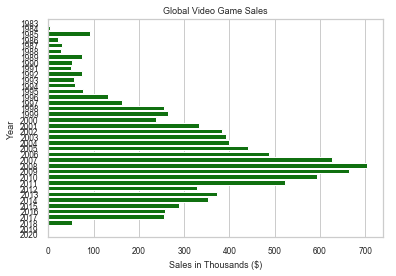

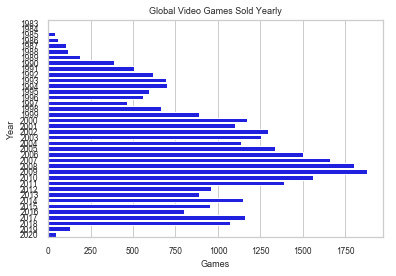

In [3]:
# game sales by year
by_year = games.groupby(by=games['Release_Date'].dt.year).sum()
by_year.reset_index(inplace=True)
sns.set(style='whitegrid', font_scale=0.75)
gsby = sns.barplot(x='Global_Sales', y='Release_Date', data=by_year, orient='h', color='green').set_title('Global Video Game Sales')
plt.xlabel('Sales in Thousands ($)')
plt.ylabel('Year')
plt.show()

# number of games released each year
sns.set(style='whitegrid', font_scale=0.75)
gpy = sns.countplot(y=games['Release_Date'].dt.year, data=games, color='blue').set_title('Global Video Games Sold Yearly')
plt.xlabel('Games')
plt.ylabel('Year')
plt.show()

	A quick look at sales and number of games each year shows a strong increase from the crash of ‘83 up to about 2009 where it starts to decrease again. Reaching a peak of $700 thousand in global sales, there is a large amount of potential money for companies to make if the proper investments have been made. But what makes a good game? Not all games will make a company money. Looking at a histogram of game scores, we can see it’s slightly left skewed, which is expected. A standard, mediocre game can get a rating of 6-7, and the largest score given appears to be an 8, leaving little room for that high 9 and 10 scores while ample room for a poor game to show just how bad it really is.

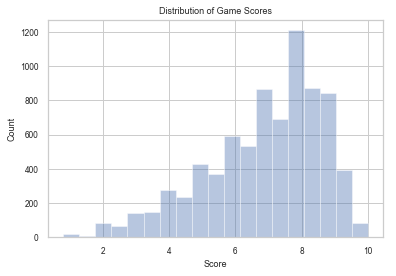

In [4]:
scores = games[np.isfinite(games['score'])] # 8k games
sns.distplot(scores.score, bins=19, kde=False).set_title('Distribution of Game Scores')
sns.set(style='ticks')
plt.ylabel('Count')
plt.xlabel('Score')
plt.show()


Since the range of data spans 30 years, each system had varying lifespans, economies, and trends to deal with. Looking at sales by each system, we can see that the PS2 clearly made the most money with its game titles, by almost 200k. X360, PS3, Wii, and DS round out the top 5 above $800k, all modern systems. The failed dreamcast (DC) can be seen with very low numbers, next to GameBoy Color (GBC), Genesis (GEN), PlayStation Vita (PSV), and WiiU before nearly a 2x increase. These are systems that all had terribly low sales for various reasons. 


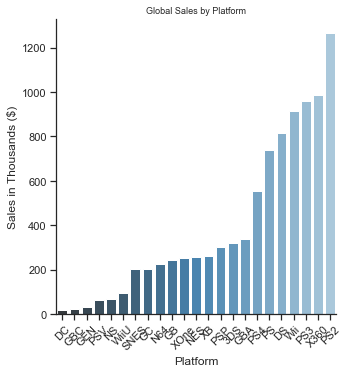

In [5]:
by_console = games.groupby(by='Platform').sum()
by_console.reset_index(inplace=True)
by_console = by_console[by_console['Platform'] != 'GG']
by_console = by_console.sort_values(['Global_Sales']).reset_index(drop=True)
order = by_console.Platform
gsbc = sns.catplot(x='Platform', y='Global_Sales', kind='bar', data=by_console, order=order, palette=('Blues_d'))
plt.xticks(rotation=45)
plt.ylabel('Sales in Thousands ($)')
sns.set(style='whitegrid', font_scale=0.75)
plt.title('Global Sales by Platform')
plt.show()

There can be several reasons as to why some systems did exceptionally well and others failed. Timing, library, technology, and several other factors all played important roles in determining success and failures in the industry, with multiple competing companies.

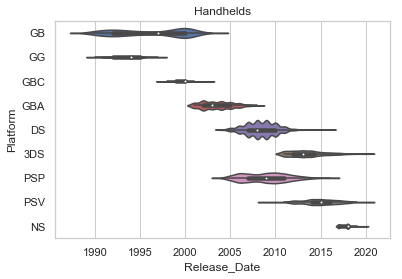

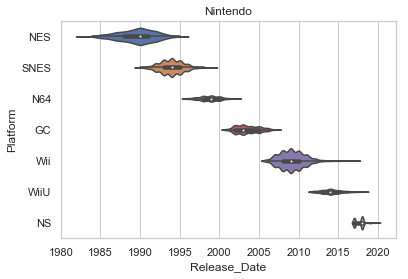

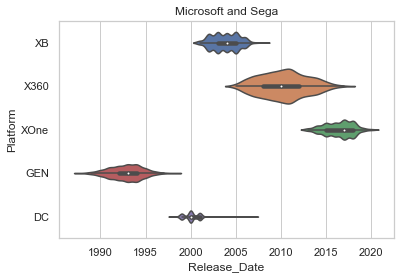

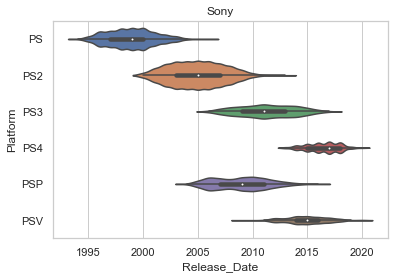

In [6]:
handheld_systems = ['GB', 'GG', 'GBC', 'GBA', 'DS', '3DS', 'PSP', 'PSV', 'NS']
nintendo_systems = ['NES', 'SNES', 'N64', 'GC', 'Wii', 'WiiU', 'NS']
microsoft_systems = ['XB', 'X360', 'XOne', 'GEN', 'DC']
ps_systems = ['PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV']
early_consoles = ['NES', 'SNES', 'GEN', 'PS', 'N64', 'DC']
advanced_consoles = ['PS2', 'GC', 'XB', 'PSP', 'DS', 'X360', 'PS3', 'Wii', 'XOne', 'PS4', 'NS']

handhelds = games[games['Platform'].isin(handheld_systems)]
nintendo = games[games['Platform'].isin(nintendo_systems)]
microsoft = games[games['Platform'].isin(microsoft_systems)]
playstation = games[games['Platform'].isin(ps_systems)]
sns.set(style='whitegrid')
sns.violinplot(x=handhelds['Release_Date'].dt.year, y='Platform', data=handhelds, scale='count', order=handheld_systems)
plt.title('Handhelds')
plt.show()
sns.violinplot(x=nintendo['Release_Date'].dt.year, y='Platform', data=nintendo, scale='count', order=nintendo_systems)
plt.title('Nintendo')
plt.show()
sns.violinplot(x=microsoft['Release_Date'].dt.year, y='Platform', data=microsoft, scale='count', order=microsoft_systems)
plt.title('Microsoft and Sega')
plt.show()
sns.violinplot(x=playstation['Release_Date'].dt.year, y='Platform', data=playstation, scale='count', order=ps_systems)
plt.title('Sony')
plt.show()


From comparing the different graphs and looking at the platforms that did well vs the ones that failed from the previous graph, we can start to see some reasons. DC for example, its release falls between the Nintendo64 (N64) and PlayStation2, both major competing consoles that had larger libraries (as seen via the thickness of the violin plots). The GEN was the next major console released after the NES, and was quickly overshadowed by the SNES. Noting that the PS2 had the largest game sales and is clearly one of the most prominent. It has the longest lifespan (13 years) as well as the largest library on any system (3510 games). The PS2 was released as the next level processing system compared to its previously released competitors (N64, 4 years and the DC, 2 years).   

Let’s look at the top selling games and see what qualities they have. The games range across several genres and platforms. Sports, action, platform, racing, puzzle, role-playing, misc, and shooter are the genres included, while platforms range from NES (Super Mario Bros and Tetris) to XOne and NS (Minecraft and Grand Theft Auto V). Since some games are released on multiple platforms, they easily generate more revenue (GTA V, Minecraft, Super Mario Bros, and Call of Duty all have 4+ platforms to bring in money from sales). 

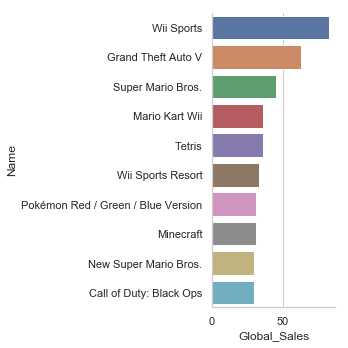

In [7]:
top_sellers = games.groupby(by='Name').sum()
top_sellers = top_sellers.sort_values(by='Global_Sales', ascending=False).head(10)
top_sellers = top_sellers.reset_index(inplace=False)
#top_sellers = top_sellers.reset_index(inplace=True)
sns.catplot(x='Global_Sales', y='Name', kind='bar', data=top_sellers)
plt.show()

Comparing sales by genre, there are clear winners when looking at revenue. Unsurprisingly, sports and action are the top two, each having over $1250k in sales. MMO, party, and music have very little sales. MMO games generally work differently. They have a smaller initial price, and then generate money via a re-occurring subscription service that constantly brings in money. Since this information only accounts for initial sales, it hides the true money generated from that genre. Party is also significantly lower, possibly as a result of the poor quality in games for the genre, as seen in the boxplot, where the average score is close to 6 for party games vs about 7 to 8 for every other genre. The box plot also shows that although sports games may bring in the largest sales, there appears to be a greater range of scores with many outliers on the lower end. Sports is one of the largest game genres, having multiple games released each year and by different publishers, so the market gets flooded with basketball, baseball, football, and soccer games.


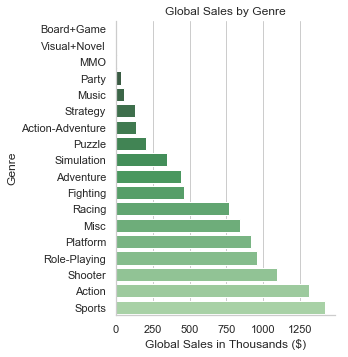

In [8]:
by_genre = games.groupby(by='Genre').sum()
by_genre.reset_index(inplace=True)
by_genre = by_genre.sort_values(['Global_Sales']).reset_index(drop=True)
order = by_genre.Genre
sns.catplot(y='Genre', x='Global_Sales', data=by_genre, kind='bar', order=order, palette=('Greens_d'))
plt.xlabel('Global Sales in Thousands ($)')
plt.title('Global Sales by Genre')
plt.show()

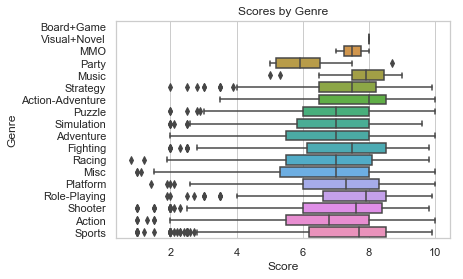

In [9]:
sns.boxplot(y='Genre', x='score', data=games, order=order)
plt.title('Scores by Genre')
plt.xlabel('Score')
plt.show()

Breaking down sales by platform, this heatmap of each year also helps to show where the powerhouses were. PS, PS2, DS, X360, Wii, PS3, and PS4 all rack up heavy sales. It can easily be seen where transitions from one platform to another occur, such as between PS and PS2 in the years 2000-2001. All values listed as 0 are less than $100k in sales globally, but still had sales. Note outlier for DC in 2007. After seeing that, it was discovered a game was actually made for the system in Japan years after the system had been completely discontinued. 

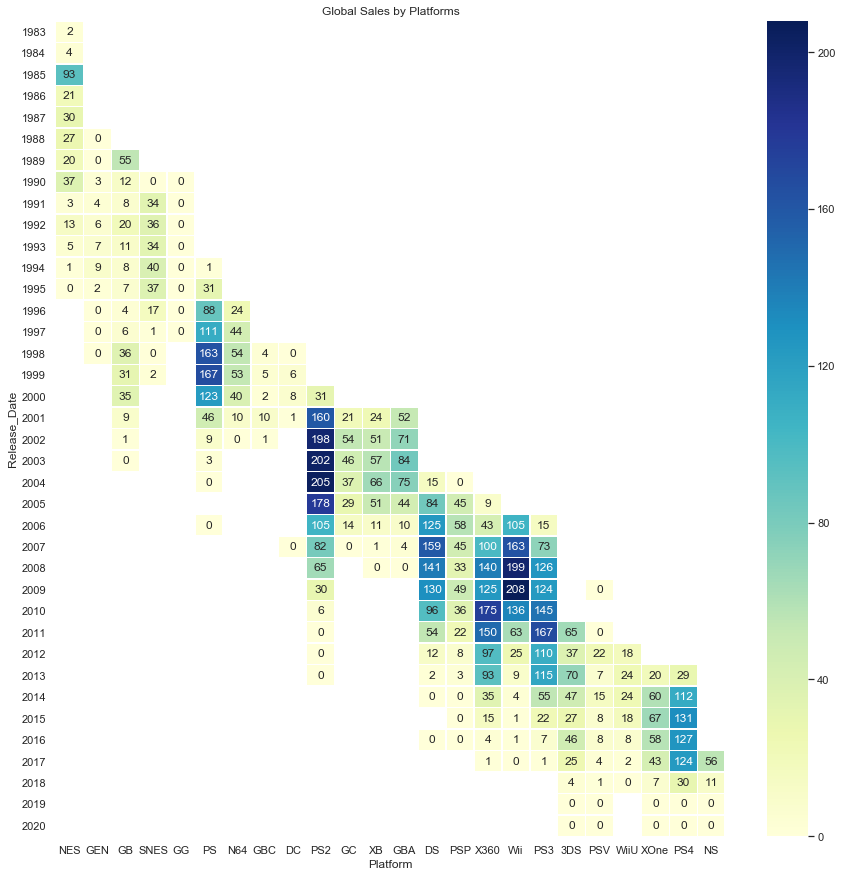

In [10]:
# average global sales per year by platform
plt.subplots(figsize=(15, 15))
test = games.groupby('Platform')['Platform'].count()
test.sort_values(ascending=True, inplace=True)
mean_test = games[games['Platform'].isin(test.index)]
abc = mean_test.groupby([mean_test['Release_Date'].dt.year, 'Platform'])['Global_Sales'].sum().reset_index()


abc = abc.pivot('Release_Date', 'Platform', 'Global_Sales')
abc = abc[['NES', 'GEN', 'GB', 'SNES', 'GG', 'PS', 'N64', 'GBC', 'DC', 'PS2', 'GC', 'XB',
                                                   'GBA', 'DS', 'PSP', 'X360', 'Wii', 'PS3', '3DS', 'PSV', 'WiiU',
                                                   'XOne', 'PS4', 'NS']]
abc = np.round(abc, decimals=0) # remove decimals to avoid scientific notation
sns.heatmap(abc, annot=True, cmap='YlGnBu', linewidths=0.4, fmt='g')
plt.title('Global Sales by Platforms')
plt.yticks(rotation=0)
plt.show()

Two key elements in a game’s creation are the publisher and developer. The publisher funds the project and is responsible for manufacturing, marketing, market research, and advertising. These are the big names that everyone recognizes and are most often tied to hit titles. Publishers can have their own branch that also handles development, or outsource that to a 3rd party company. Developers are responsible for the creation of the game through software, programming, and arts. They receive the payments and direction from the publisher, reach milestones as they progress, and create the game presented by the publishers. Looking at the top ten publishers and developers by sales doesn’t bring anything surprising up. When checking the global sales per game released, the numbers change slightly. Nintendo maintains its superior lead, with $180k per game published, with EA sports following 2nd at $80k per game. 


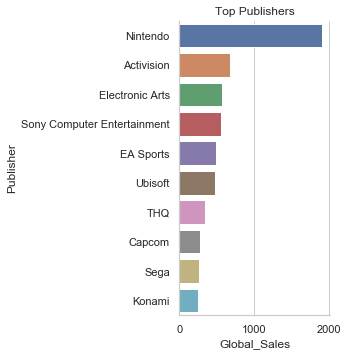

In [11]:
top_pub = games.groupby('Publisher').sum()
top_pub = top_pub.sort_values('Global_Sales', ascending=False).head(10)
top_pub = top_pub.reset_index(drop=False)
ord = list(top_pub.Publisher.head(10))
sns.catplot(x='Global_Sales', y='Publisher', data=top_pub, kind='bar', order=ord)
plt.title('Top Publishers')
plt.show()

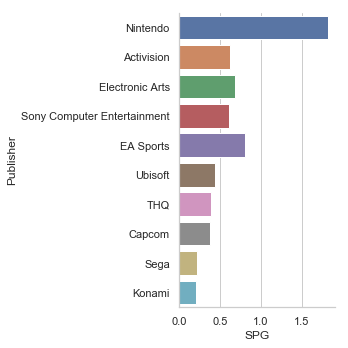

In [12]:
# publishers by sales/game
game_count = ([1048, 1089, 836, 910, 609, 1089, 863, 726, 1203, 1258])
se = pd.Series(game_count)
top_pub['Game_Count'] = se.values
ppg = top_pub['Global_Sales']/top_pub['Game_Count']
top_pub['SPG'] = ppg.values
sns.catplot(x='SPG', y='Publisher', data=top_pub, kind='bar', order=ord)

Building a model to predict the global sales of a game will be interesting, as there are many facets that can account for a game being received well or not. Time of release will be an important factor, as games released in the beginning of the year may do better or worse than games released during the Christmas rush. There is also much more to be looked into, between systems, genres, platforms, and regional nuances, but there is only so much time. In future, I’ll have to add more in depth analysis to see what more information can be dug up.
